<a href="https://colab.research.google.com/github/Fred66X/DS_Projects/blob/main/MNIST_Neural_Networks_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Networks Test  - MNIST Model - Deep Learning

## Overfitting techniques

We will build a network with its callbacks but adding three different techniques that can be used separately:

1. **BatchNormalization()** - only worth it if we have a number of layers greater than 8 or so
2. **Weight Decay** - it is put in each layer that we want to apply with the option `kernel_regularizer = l2(0.001)` (remember that you have to migrate the optimizer to SGD) - More information https://keras.io/api/layers/regularizers/
3. **Most optimized random weight initializer in the layers** - `kernel_initializer = 'he_uniform'` (by default, Keras, uses the `glorot_uniform`

## 1. Library


In [ ]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Función para regular el Weight Decay en la definición de las capas
from tensorflow.keras.regularizers import l2

# Como useramos l2(), Adam no se puede usar como optimizador
from tensorflow.keras.optimizers import SGD

We built a simple neural network model for the MNIST data, which in summary are:
- Input data: 28x28 pixel images with a gray channel (values ​​from 1 to 256, integers)
- Output data (labels): we assign each image a value from 0 to 9, a total of 10 classes
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png">

To build the architecture of the neural network, the **.Sequential()** method of Keras is followed (from input to output):

- **Input** - The input_shape is essential in that first layer and is immovable
- **Hidden** - Set of convolutions, flatten and dense
- **Output** - A dense layer (fully connected) with 10 neurons (**the 10 output classes**) and softmax activation - remember that this is immovable

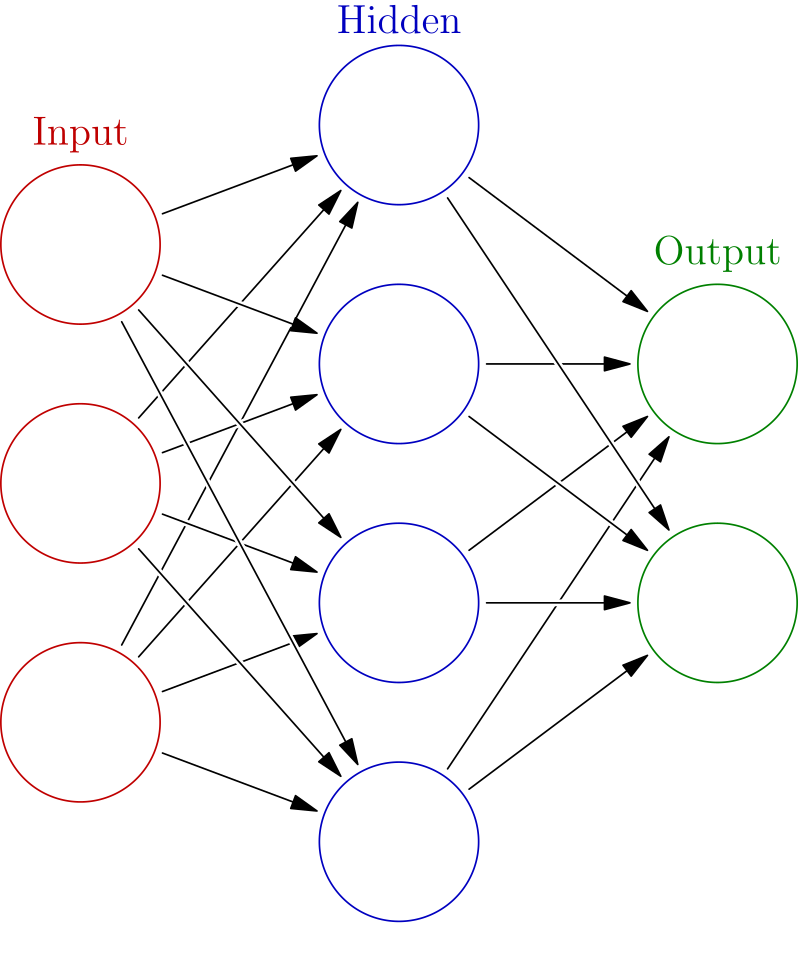

Applying BatchNormalization(), kernel_regularizer (with the l2 function and parameter 0.001), and the kernel_initializer

In [ ]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(filters=16, kernel_size=(3,3), padding = 'same',
                           activation='relu', kernel_regularizer = l2(0.001), kernel_initializer = 'he_uniform',
                           input_shape=(28,28,1))) # Shape de la imagen más los canales de color
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(filters=16, kernel_size=(3,3), padding = 'same',
                           strides=1, activation='relu', __, __))
__
model.add(ks.layers.MaxPooling2D((2,2)))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(filters=64, kernel_size=(3,3), padding = 'same',
                           strides=1, activation='relu', __, __))
__
model.add(ks.layers.Conv2D(filters=64, kernel_size=(3,3), padding = 'same',
                           strides=1, activation='relu', __, __))
__
model.add(ks.layers.MaxPooling2D((2,2)))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same',
                           strides=1, activation='relu', __, __))
__
model.add(ks.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same',
                           strides=1, activation='relu', __, __))
__
model.add(ks.layers.MaxPooling2D((2,2)))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu', __, __))
__
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu', __, __))
__
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Dense(10, activation='softmax')) # capa de salida de 10 neuronas


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                        

To review a model, we simply call the model's **.summary()** method

From **.summary()** we extract very relevant information: the number of parameters per layer and the total to train.4

Note that 28x28 are 784 values, so that is what we have as input. Those 784 neurons are linked with 16 (16 * 784 weights + 16 bias = 12560) and those 16 with the 10 outputs (16 * 10 weights + 10 bias). A total of 12730 parameters to learn.

## 3. Optimizer, error function

We define the parameters of the model for training:
* **Loss** - Error function (cost function) - We opted for the Sparse Categorical Crosstentropy because we are classifying images
* **Optimizer** - which cost function optimizer will we use, in this example we will **use SGD with momentum** because the `kernel_regularizer = l2(0.001)` does not get along well with Adam.
* **Metrics** - which metric will we use to evaluate the model... in this case we use Accuracy

In [ ]:
new_sgd = SGD(learning_rate = 0.01, momentum=0.9)

model.compile(optimizer=new_sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

## 4. Data preparation

We load the MNIST data from the datasets directly from the Keras libraries. These are already arranged in train and test

**Important detail:**
> The neural network requires that the inputs be real numbers, and we will do this by forcing the division of the values ​​inside the 28x28 matrices (which have values ​​from 0 to 255) by 255.0 (a real)

In [ ]:
mnist = ks.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()



In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

Let's draw a sample of images from the MNIST dataset, and see if it looks anything like what we expect.
First, we see what kind of data I have, then we map those matrices to a grayscale using PlotLy's **.get_cmap()** method with the first nine numbers in the dataset.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


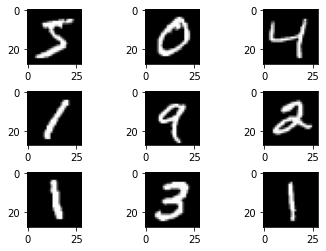

In [ ]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.subplots_adjust(hspace = 0.5)
plt.show()

As we want to do validation while we train (very practical)

In [ ]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


In [ ]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(50000, 28, 28), y=(50000,)
Test: X=(10000, 28, 28), y=(10000,)
Validation: X=(10000, 28, 28), y=(10000,)


In [ ]:
y_train

array([5, 0, 4, ..., 8, 4, 8], dtype=uint8)

In [ ]:
x_train_cnn = x_train.reshape(50000, 28, 28, 1)
x_test_cnn = x_test.reshape(10000, 28, 28, 1)
x_val_cnn = x_val.reshape(10000, 28, 28, 1)

print('Train CNN: X=%s, y=%s' % (x_train_cnn.shape, y_train.shape))
print('Test CNN: X=%s, y=%s' % (x_test_cnn.shape, y_test.shape))
print('Validation CNN: X=%s, y=%s' % (x_val_cnn.shape, y_val.shape))

Train CNN: X=(50000, 28, 28, 1), y=(50000,)
Test CNN: X=(10000, 28, 28, 1), y=(10000,)
Validation CNN: X=(10000, 28, 28, 1), y=(10000,)


## 5. TRAINING


We will start with 30 epochs, that is, 30 complete passes of the dataset (which will also be with mini-batches internally), by default in Keras, **the batch_size is 32**.





### 5.1 We define the callbacks to be executed in each epoch

2 DIFFERENT CALLBACKS

<b>EarlyStopping</b>
It is the monitoring of the training variables in each epoch (generally on validation tests: error/loss or accuracy). Additionally, it has a parameter called <i>patience</i> to indicate how many epochs we allow the metric not to improve (lowest error or maximum accuracy).

<b>ModelCheckpoint</b>
It allows each epoch to store the neural network at that moment in a temporary zone. All epochs can be stored or only those specified in the parameters (via monitoring of some metric such as accuracy or error).

In [ ]:
earlystopping_val_loss = EarlyStopping(monitor='val_loss', patience = 15)
earlystopping_val_accuracy = EarlyStopping(monitor='val_accuracy', patience = 15)

In [ ]:
modelcheckpoint_best_accuracy = ModelCheckpoint('/tmp', monitor='val_loss', save_best_only=True)

### 5.1 tRAINING

In [ ]:
t = time.perf_counter()

In [ ]:
history = model.fit(x_train_cnn, y_train, epochs=200,
                    use_multiprocessing=False,
                    batch_size= 512,
                    validation_data=(x_val_cnn, y_val),
                    callbacks=[modelcheckpoint_best_accuracy, earlystopping_val_loss, earlystopping_val_accuracy])

Epoch 1/200
98/98 [==============================] - 10s 80ms/step - loss: 4.1206 - accuracy: 0.6002 - val_loss: 6.3011 - val_accuracy: 0.2339
Epoch 2/200
98/98 [==============================] - 4s 38ms/step - loss: 3.1072 - accuracy: 0.8863 - val_loss: 7.8848 - val_accuracy: 0.2020
Epoch 3/200
98/98 [==============================] - 7s 75ms/step - loss: 2.8862 - accuracy: 0.9228 - val_loss: 5.4009 - val_accuracy: 0.3886
Epoch 4/200
98/98 [==============================] - 8s 77ms/step - loss: 2.7343 - accuracy: 0.9393 - val_loss: 3.4444 - val_accuracy: 0.7393
Epoch 5/200
98/98 [==============================] - 7s 74ms/step - loss: 2.6136 - accuracy: 0.9471 - val_loss: 2.7747 - val_accuracy: 0.8871
Epoch 6/200
98/98 [==============================] - 7s 76ms/step - loss: 2.5001 - accuracy: 0.9537 - val_loss: 2.5622 - val_accuracy: 0.9254
Epoch 7/200
98/98 [==============================] - 7s 73ms/step - loss: 2.3964 - accuracy: 0.9586 - val_loss: 2.3454 - val_accuracy: 0.9630
Epoch

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:11:12.887814


## 6. results

Let's get a graph of how the error and accuracy evolve in each epoch in the training data and in the validation.

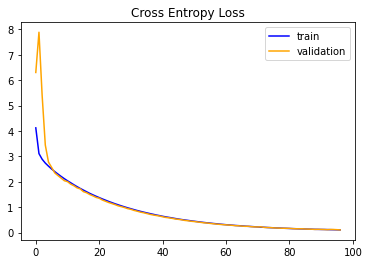

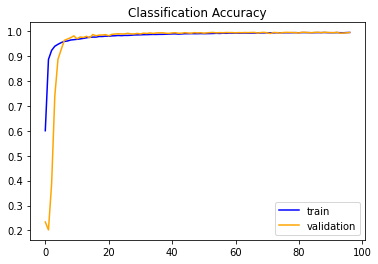

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

We retrieve the best model from the ModelCheckpoint

In [ ]:
model.load_weights('/tmp')

Let's evaluate the model against the test values

In [ ]:
model.evaluate(x_test_cnn,  y_test, verbose=2)

313/313 - 1s - loss: 0.1045 - accuracy: 0.9937 - 1s/epoch - 4ms/step


[0.10451316833496094, 0.9937000274658203]

We can see that the cost is stable. Also, the accuracy fluctuates a lot. It cannot be said that it is a very good model.

Let's see what kind of predictions I am getting on the test set (let's draw the images and their classifications)

In [ ]:
predictions = model.predict(x_test_cnn)

Painting by different conditions based on results

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

We draw the first digits, with the predictions and their real values ​​(a total of 20 images, so as not to overuse your laptops)

We color the correct predictions in blue and the errors in red

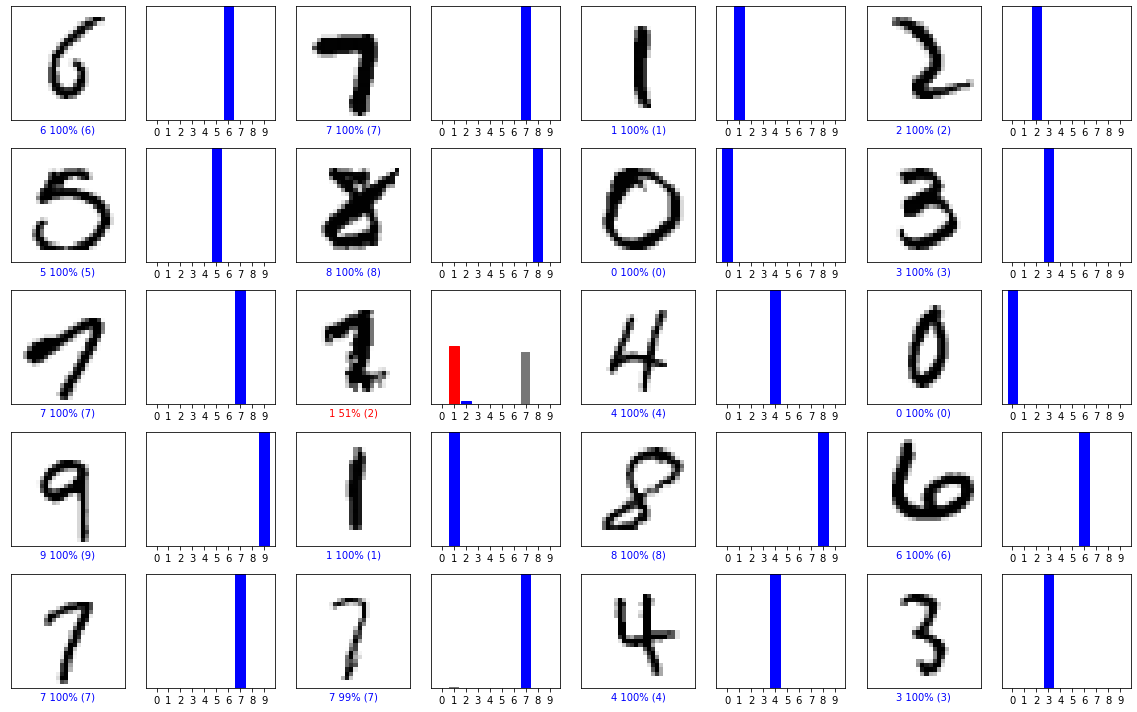

In [ ]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('mnist_model.h5')